# Урок 9. Python применение продвинутых методов

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.  
Mobile Games AB Testing with Cookie Cats  
Измеряем метрику - количество раундов и необходимо вычистить случаи,  
когда retension 1 - false, а retension 7 - true  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import kstest

In [2]:
df = pd.read_csv('Lesson9_cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [5]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [6]:
df.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [7]:
df = df[df.sum_gamerounds < 3000]

In [8]:
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


In [9]:
A = df.version.groupby(df.version == 'gate_30').count()
B = df.version.groupby(df.version == 'gate_40').count()
print(A)
print(B)

version
False    45489
True     44699
Name: version, dtype: int64
version
False    44699
True     45489
Name: version, dtype: int64


Число версий примерно одинаковы.  
Версия gate_30 будит называться контрольной группой A.  
Версия gate_40 будит называться тестовой группой B.  

In [10]:
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

pvalue очень блиско к 0.05 соответственно этого теста будит не достаточно для принятия решения.

In [11]:
ttest_ind(df[df.version == 'gate_30'].sum_gamerounds,
          df[df.version == 'gate_40'].sum_gamerounds)

TtestResult(statistic=0.0633675766982082, pvalue=0.9494739458256001, df=90186.0)

In [12]:
print(kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm'))
print(kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Распределение не нормальное.

Text(0.5, 1.0, 'Number of game rounds players on the first week')

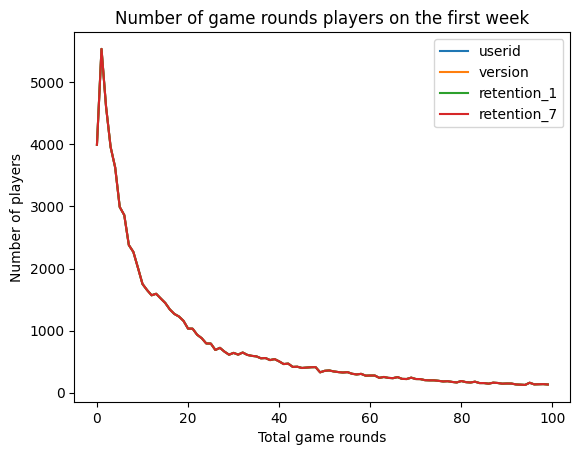

In [13]:
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week')

График показывает, что большенство пользователей играет менее 20 раундов.  
Построим гистограммный график различных распределений групп AB.  
Чтобы получить более детальное представление о низкой и высокой активности пользователей изменим наше распределение выборок.

In [14]:
plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


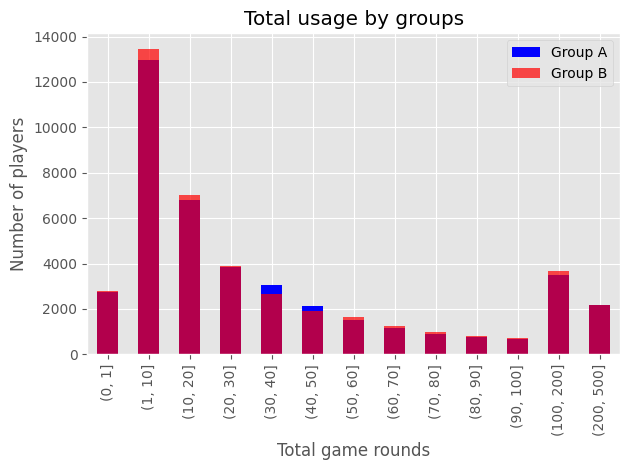

In [15]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

Гафик показывает, что между двумя версиями вообщем нет большой разници.  
Небольшие различия есть в пределах 30 - 40 сыгранных раундов.  

Посмотрим какое удержание в течении 1 дня.

In [16]:
oneday = df.retention_1.sum()/df.retention_1.count()
print(str(oneday*100)+'%')

44.521444094558035%


Посмотрим какое удержание в течении 1 дня для групп.

In [63]:
oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday*100)

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64


Обе версии имеют практически одинаковые результаты.  
Четково ответа стоит ли применять изменение мы не получили.  
Для принятия решения воспользуемся Bootstrapp для более детального иследования.  

In [18]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.450203  0.441156
retention_1  0.450180  0.440518
retention_1  0.448207  0.438747
retention_1  0.450278  0.436404
retention_1  0.445244  0.442632
...               ...       ...
retention_1  0.448568  0.444994
retention_1  0.446525  0.447489
retention_1  0.446510  0.440409
retention_1  0.446494  0.442969
retention_1  0.450661  0.441269

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

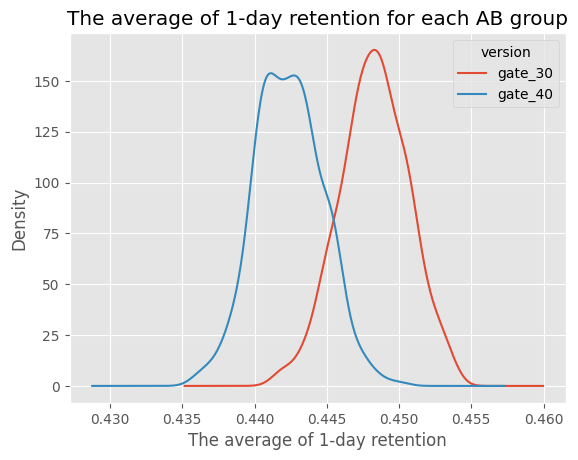

In [19]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

Увеличим разницу в удержании в течение 1 дня.

Text(0.5, 1.0, 'Zooming % difference')

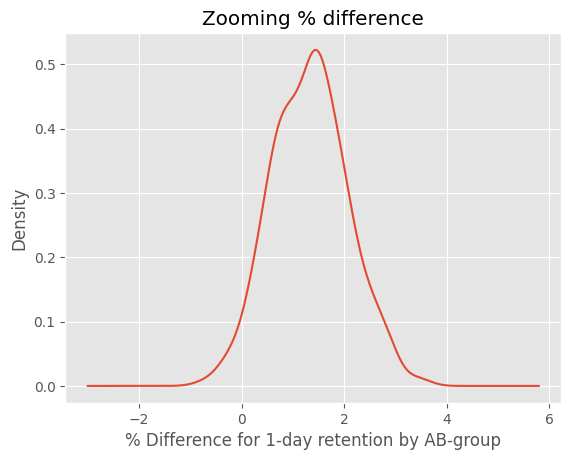

In [20]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

Из графика видно, что наиболее вероятная разница 1-2% в пользу ворот на 30 уровне.  

Посчитаем в скольки процентах случаев разница больше 0.

In [21]:
prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

96.8%


Вывод:  
Существует высокая вероятность того, что удержание в течении 1 дня лучше, когда ворота находятся на уровне 30.  

Дальше расчитаем удержание в течении 7 дней для двух AB групп.  

In [22]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

Здесь так же процент удержания выше у gate_30.  

Для более точного расчета воспользуемся bootstrap-анализом.  

In [23]:
boot_7d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

version       gate_30   gate_40
retention_7  0.187499  0.181633
retention_7  0.190794  0.181569
retention_7  0.186723  0.181662
retention_7  0.190279  0.183814
retention_7  0.191034  0.181639


0.998


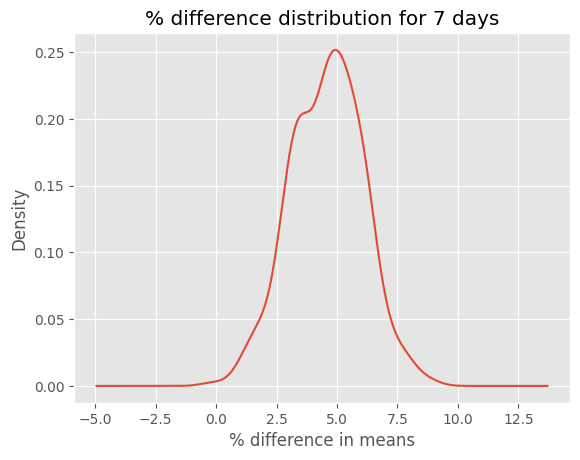

In [24]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days')

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

In [25]:
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])
print(str(prob*100)+'%')

99.8%


Вывод:  
Наши иследования показали, что удержание в течении 7 дней выше, когда ворота ноходятся на уровне 30.  
Следовательно для удержания аудитории не рекомендуется перемещать варота с 30 уровня на 40.  

Заключительные выводы:
1. У нас есть достаточно статистических данных, чтобы сказать, что 7-дневное удержание выше, когда гейт находится на уровне 30, чем когда он находится на уровне 40, так же, как мы пришли к выводу для 1-дневного удержания. Если мы хотим сохранить высокий уровень удержания потребителей, мы не должны перемещать гейт с уровня 30 на уровень 40, это означает, что мы сохраняем наш метод контроля в текущей системе гейтов.

2. Что касается будущих стратегий, то гейм-дизайнеры могут учитывать, что, подталкивая игроков к перерыву, когда они достигают ворот, удовольствие от игры откладывается. Но, когда ворота переносятся на 40 уровень, они с большей вероятностью выйдут из игры, потому что им просто неинтересно.